### DCGAN PyTorch implementation on Fashion MNIST Data
### ref pytorch official tutorials

In [1]:
import torch 
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.nn.modules.activation import LeakyReLU
from torch.optim import Adam
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML



# Set random seed for reproducibility
manualSeed = 10
torch.manual_seed(manualSeed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
image_size = 64
batch_size = 64
dataset = FashionMNIST(root='./', train=True, download=True,
                       transform = transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.ToTensor(),
                           transforms.Normalize(0.5, 0.5),
                       ]))
                       
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [3]:
# Visualize
images, labels = next(iter(dataloader))
print(f'shape of the images (B, C, H, W) is %s' %[images.shape])

shape of the images (B, C, H, W) is [torch.Size([64, 1, 64, 64])]


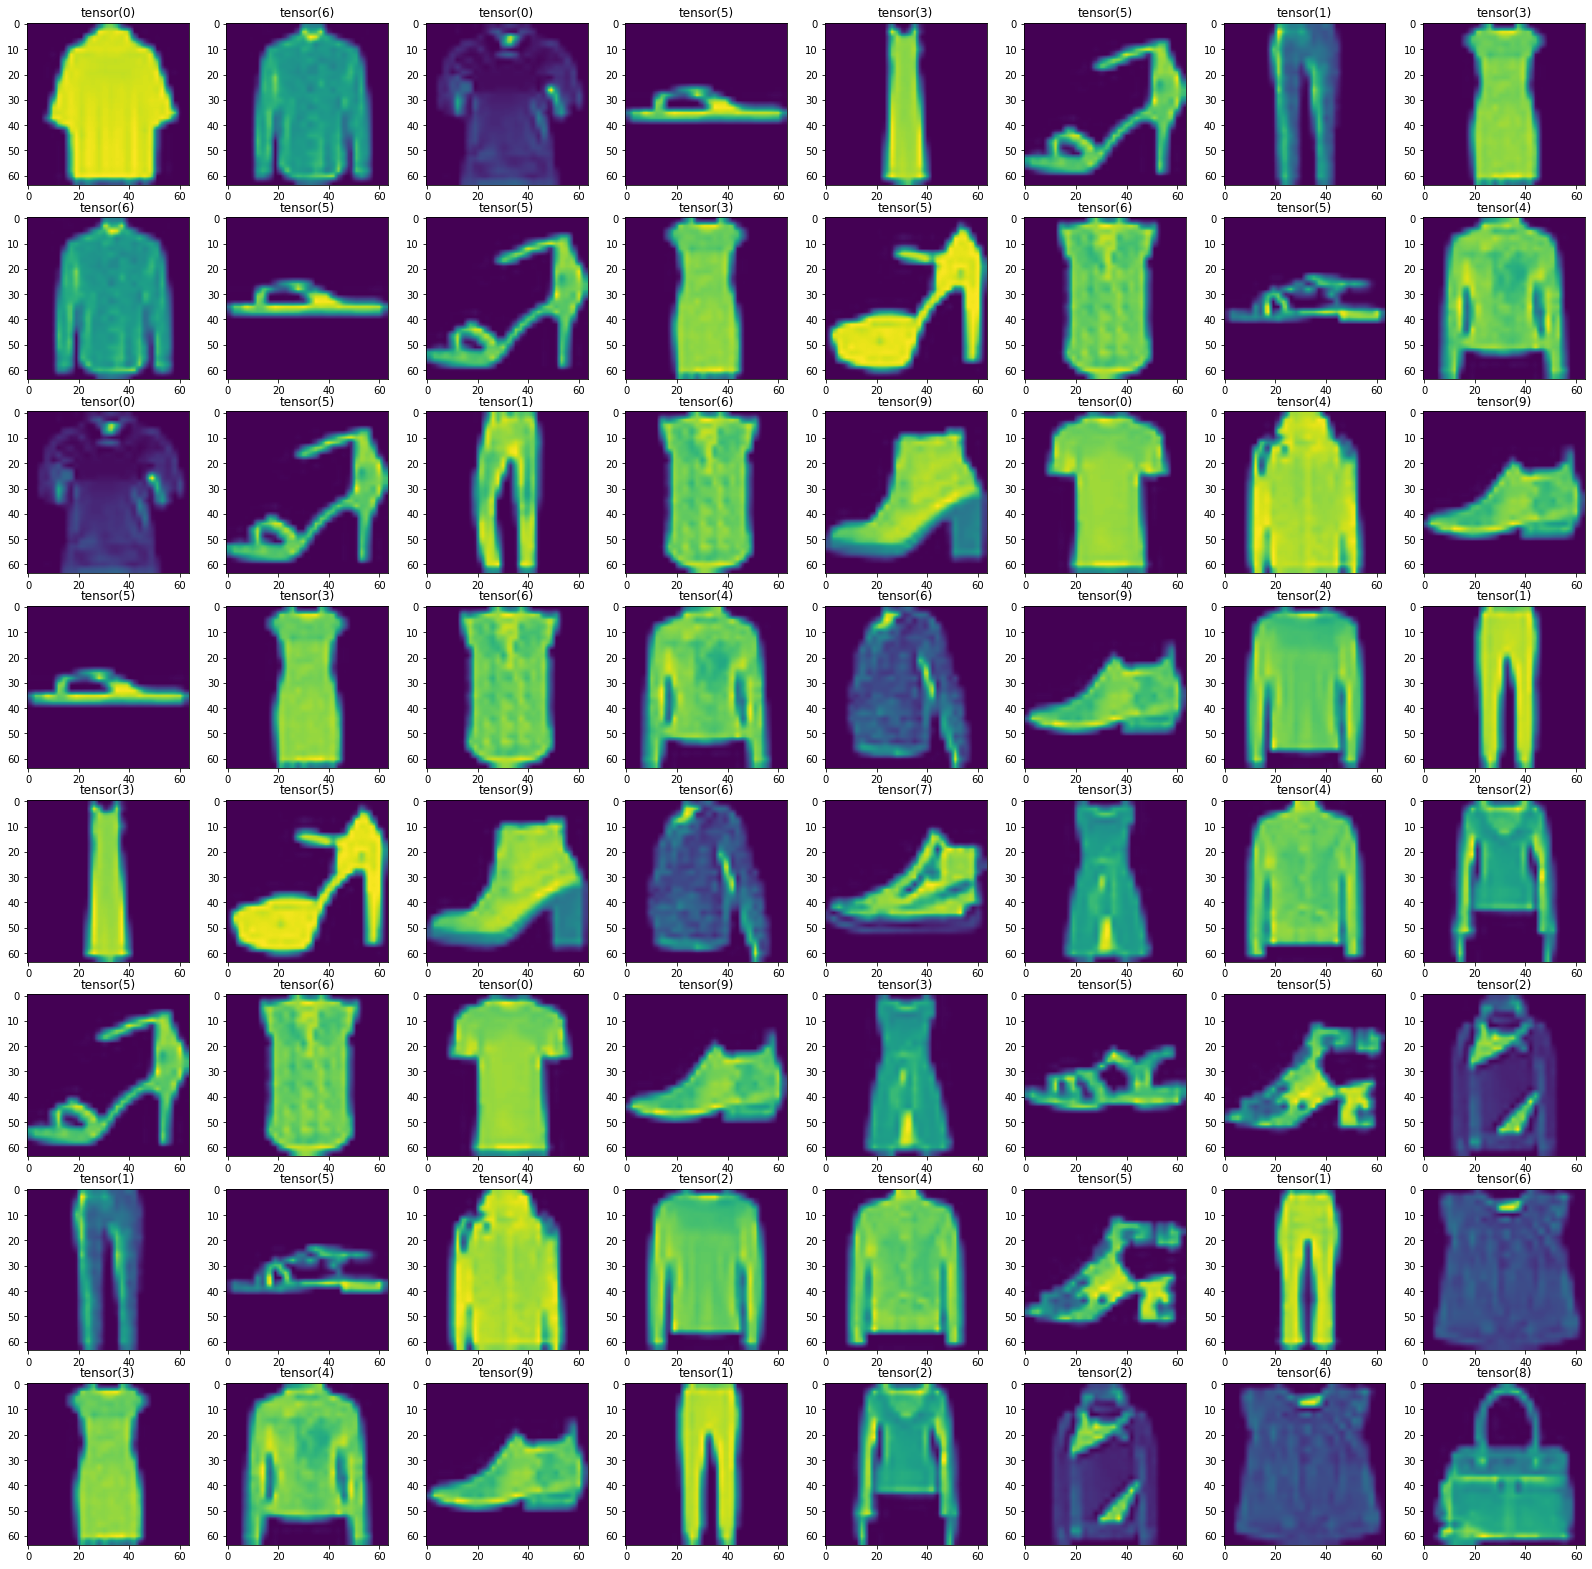

In [4]:
fig, ax = plt.subplots(ncols=8, nrows=8, figsize=(28,28))
for i in range(8):
    for j in range(8):
        ax[i][j].imshow(np.squeeze(images[(i+1)*(j+1)-1]))
        ax[i][j].title.set_text(labels[(i+1)*(j+1)-1])

In [5]:

# Generator code
ngf=64
nz=100
nc=1 # black and white

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, kernel_size=(4,4), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2),
            # after this size of input latent is ngf*8 * 4 * 4 (To cal this take reverse of conv2d given input_size 4, ker 4, pad0, str1 then o/p size = 1)
            nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=(4,4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=(4,4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=(4,4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(ngf, nc, kernel_size=(4,4), stride=2, padding=1, bias=False),
            nn.Tanh()
        )

        self.apply(self._init_weights)

  
    def forward(self, input):
        return self.gen(input)
    
    # Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
    def _init_weights(self, module):
      if isinstance(module, nn.ConvTranspose2d):
          module.weight.data.normal_(mean=0.0, std=0.02)
          if module.bias is not None:
              module.bias.data.zero_()
      elif isinstance(module, nn.BatchNorm2d):
          module.weight.data.normal_(mean=1.0, std=0.02)
          if module.bias is not None:
              module.bias.data.zero_()

In [6]:
# Initializing the generator
netG = Generator().to(device)
print(netG)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=

In [7]:
# Discriminator code
ndf=64

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.dis = nn.Sequential(
        nn.Conv2d(nc, ndf, kernel_size=(4,4), stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),

        
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),

        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),

        # state size. (ndf*8) x 4 x 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )
    self.apply(self._init_weights)

  def forward(self, input):
    return self.dis(input)
    
  # Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
  def _init_weights(self, module):
    if isinstance(module, nn.ConvTranspose2d):
        module.weight.data.normal_(mean=0.0, std=0.02)
        if module.bias is not None:
            module.bias.data.zero_()
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.normal_(mean=1.0, std=0.02)
        if module.bias is not None:
            module.bias.data.zero_()

In [8]:
# Initializing the Discriminator
netD = Discriminator().to(device)
print(netD)

Discriminator(
  (dis): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [20]:
# Training Loop
num_epochs = 5
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Train with all-real batch
        netD.zero_grad()
        # Format batch
        # here the data has 'images', 'labels' of FashionMNIST in a list. we need only images
        data = data[0].to(device)
        
        label = torch.full((64,), real_label, dtype=torch.float, device=device)
        output = netD(data).view(-1)  #todo
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(64, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        
        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/937]	Loss_D: 0.0080	Loss_G: 6.6112	D(x): 0.9987	D(G(z)): 0.0067 / 0.0022
[0/5][50/937]	Loss_D: 0.0018	Loss_G: 9.2344	D(x): 0.9985	D(G(z)): 0.0003 / 0.0002
[0/5][100/937]	Loss_D: 0.0030	Loss_G: 7.8493	D(x): 0.9979	D(G(z)): 0.0009 / 0.0007
[0/5][150/937]	Loss_D: 0.0024	Loss_G: 7.2580	D(x): 0.9994	D(G(z)): 0.0018 / 0.0010
[0/5][200/937]	Loss_D: 0.0030	Loss_G: 7.6223	D(x): 0.9994	D(G(z)): 0.0024 / 0.0010
[0/5][250/937]	Loss_D: 0.0025	Loss_G: 7.5506	D(x): 0.9999	D(G(z)): 0.0024 / 0.0011
[0/5][300/937]	Loss_D: 0.0023	Loss_G: 7.9486	D(x): 1.0000	D(G(z)): 0.0023 / 0.0009
[0/5][350/937]	Loss_D: 0.0001	Loss_G: 13.2601	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][400/937]	Loss_D: 0.0004	Loss_G: 10.1034	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[0/5][450/937]	Loss_D: 0.0005	Loss_G: 8.7973	D(x): 0.9999	D(G(z)): 0.0004 / 0.0003
[0/5][500/937]	Loss_D: 0.0016	Loss_G: 9.1826	D(x): 0.9989	D(G(z)): 0.0005 / 0.0003
[0/5][550/937]	Loss_D: 0.0010	Loss_G: 8.6415	D(x): 0.9995	D(G(

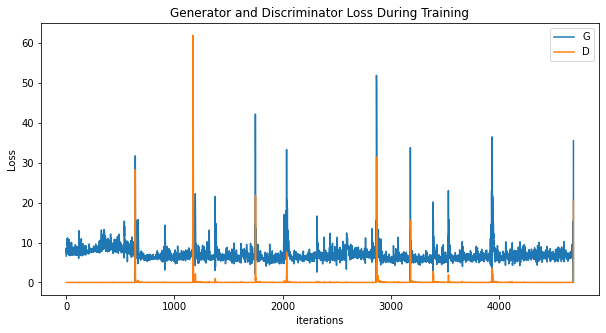

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

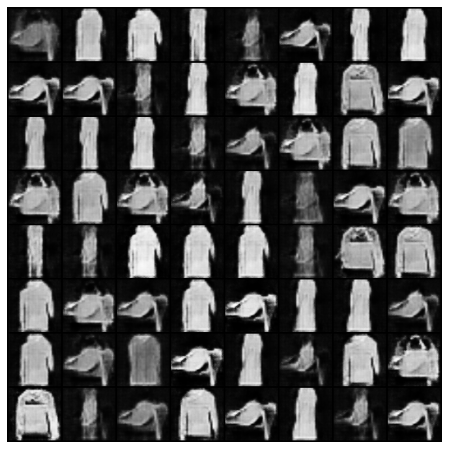

In [22]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

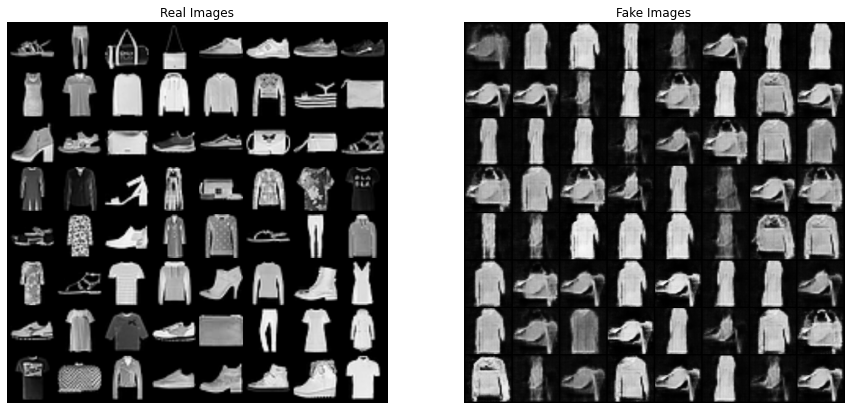

In [23]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [16]:
PATH = 'modelparams'
torch.save({
    'gen_model_state_dict': netG.state_dict(),
    'des_model_state_dict': netD.state_dict(),
    'gen_opt_state_dict': optimizerG.state_dict(),
    'des_opt_state_dic': optimizerD.state_dict(),
    'epoch':epoch,
    'g_loss':G_losses,
    'd_loss':D_losses,
    'd_x': D_x,
    'D_G_z1':D_G_z1,
    'D_G_z2': D_G_z2
}, PATH)

In [19]:
netG = Generator().to(device)
optimizerG = Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
netD = Discriminator().to(device)
optimizerD = Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))


checkpoint = torch.load(PATH)
netG.load_state_dict(checkpoint['gen_model_state_dict'])
netD.load_state_dict(checkpoint['des_model_state_dict'])
optimizerG.load_state_dict(checkpoint['gen_opt_state_dict'])
optimizerD.load_state_dict(checkpoint['des_opt_state_dic'])
epoch = checkpoint['epoch']
G_losses = checkpoint['g_loss']
D_losses = checkpoint['d_loss']
